# Assignment 3_2: Echo State Networks

In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import Ridge
import matplotlib.pyplot as plt
import torch
import torch.utils.data as data
import torch.nn.functional as F
import torch.optim as optim

from esn import *
from learning import *

In [2]:
narma_df = pd.read_csv('../NARMA10.csv', header=None)
narma_df.iloc[:, :20] # visualize the first 20 columns

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,0.083964,0.48934,0.35635,0.25024,0.23554,0.029809,0.34099,0.021216,0.035723,0.26082,0.048365,0.40907,0.40877,0.36122,0.074933,0.32980,0.25930,0.48649,0.32450,0.40017
1,0.000000,0.00000,0.00000,0.00000,0.00000,0.000000,0.00000,0.000000,0.000000,0.00000,0.132850,0.17536,0.37127,0.36481,0.337070,0.20447,0.33003,0.20726,0.18825,0.28343


In [3]:
x_data = torch.tensor(narma_df.iloc[0].values, dtype=torch.float32) # float 32 for better memory efficiency
y_data = torch.tensor(narma_df.iloc[1].values, dtype=torch.float32)

# 4000 tr, 1000 val, 5000 test (WARNING: load entire dataset in memory ONLY because it is small and also the NN is quite small)
dev_x, dev_y = x_data[:5000], y_data[:5000] # only used for retraining (train + val sets)

test_x, test_y = x_data[5000:], y_data[5000:]

train_x, val_x = dev_x[:4000], dev_x[4000:]
train_y, val_y = dev_y[:4000], dev_y[4000:]

In [4]:
dev_x = dev_x.unsqueeze(1).unsqueeze(1) # needed shape by the model
train_x = train_x.unsqueeze(1).unsqueeze(1) # needed shape by the model
val_x = val_x.unsqueeze(1).unsqueeze(1) # needed shape by the model

train_x.shape, val_x.shape, dev_x.shape # check shapes (L, N, D)

(torch.Size([4000, 1, 1]), torch.Size([1000, 1, 1]), torch.Size([5000, 1, 1]))

In [17]:
hyperparams = {
    'hidden_size': [1024], 
    'ridge_regression':  [1e-6, 1e-4],
    'omhega_in': [0.2, 0.8],
    'omhega_b': [0.3, 0.01],
    'rho': [0.8, 0.9],
    'washout': [100, 1000],
}

model_selection_history = grid_search(hyperparams, train_x, train_y, val_x, val_y, n_iter=5) 

df = pd.DataFrame.from_dict(model_selection_history, orient='index')
df.to_csv('esn_grid_search.csv')

In [64]:
df_results = pd.read_csv('esn_grid_search.csv', index_col=0)
df_results.sort_values(by='val_mse_mean', ascending=True).head(10)

,hidden_size,ridge_regression,omhega_in,omhega_b,rho,washout,train_mse_mean,train_mse_var,val_mse_mean,val_mse_var
config_4,1024,0.000001,0.8,0.0,0.8,100,0.000059,8.708628e-12,0.000010,1.661034e-12
config_5,1024,0.000001,0.8,0.0,0.8,1000,0.000060,6.460433e-12,0.000012,5.154953e-12
config_12,1024,0.000100,0.8,0.0,0.8,100,0.000075,2.074952e-11,0.000020,6.440906e-12
config_6,1024,0.000001,0.8,0.0,0.9,100,0.000070,4.323358e-11,0.000020,6.407397e-12
config_14,1024,0.000100,0.8,0.0,0.9,100,0.000068,3.481315e-11,0.000020,7.584803e-12
config_13,1024,0.000100,0.8,0.0,0.8,1000,0.000077,1.169117e-11,0.000022,1.970927e-11
config_7,1024,0.000001,0.8,0.0,0.9,1000,0.000064,2.254458e-10,0.000023,5.274659e-12
config_15,1024,0.000100,0.8,0.0,0.9,1000,0.000081,9.908429e-10,0.000025,2.612598e-11
config_2,1024,0.000001,0.2,0.0,0.9,100,0.000064,1.377428e-12,0.000030,2.478000e-11
config_3,1024,0.000001,0.2,0.0,0.9,1000,0.000070,9.860239e-12,0.000033,4.990245e-12


In [67]:
esn = RegressorESN(1, 1024, 1e-3, 0.4, 0.1, 0.8)
h = esn.fit(train_x, train_y, 100)

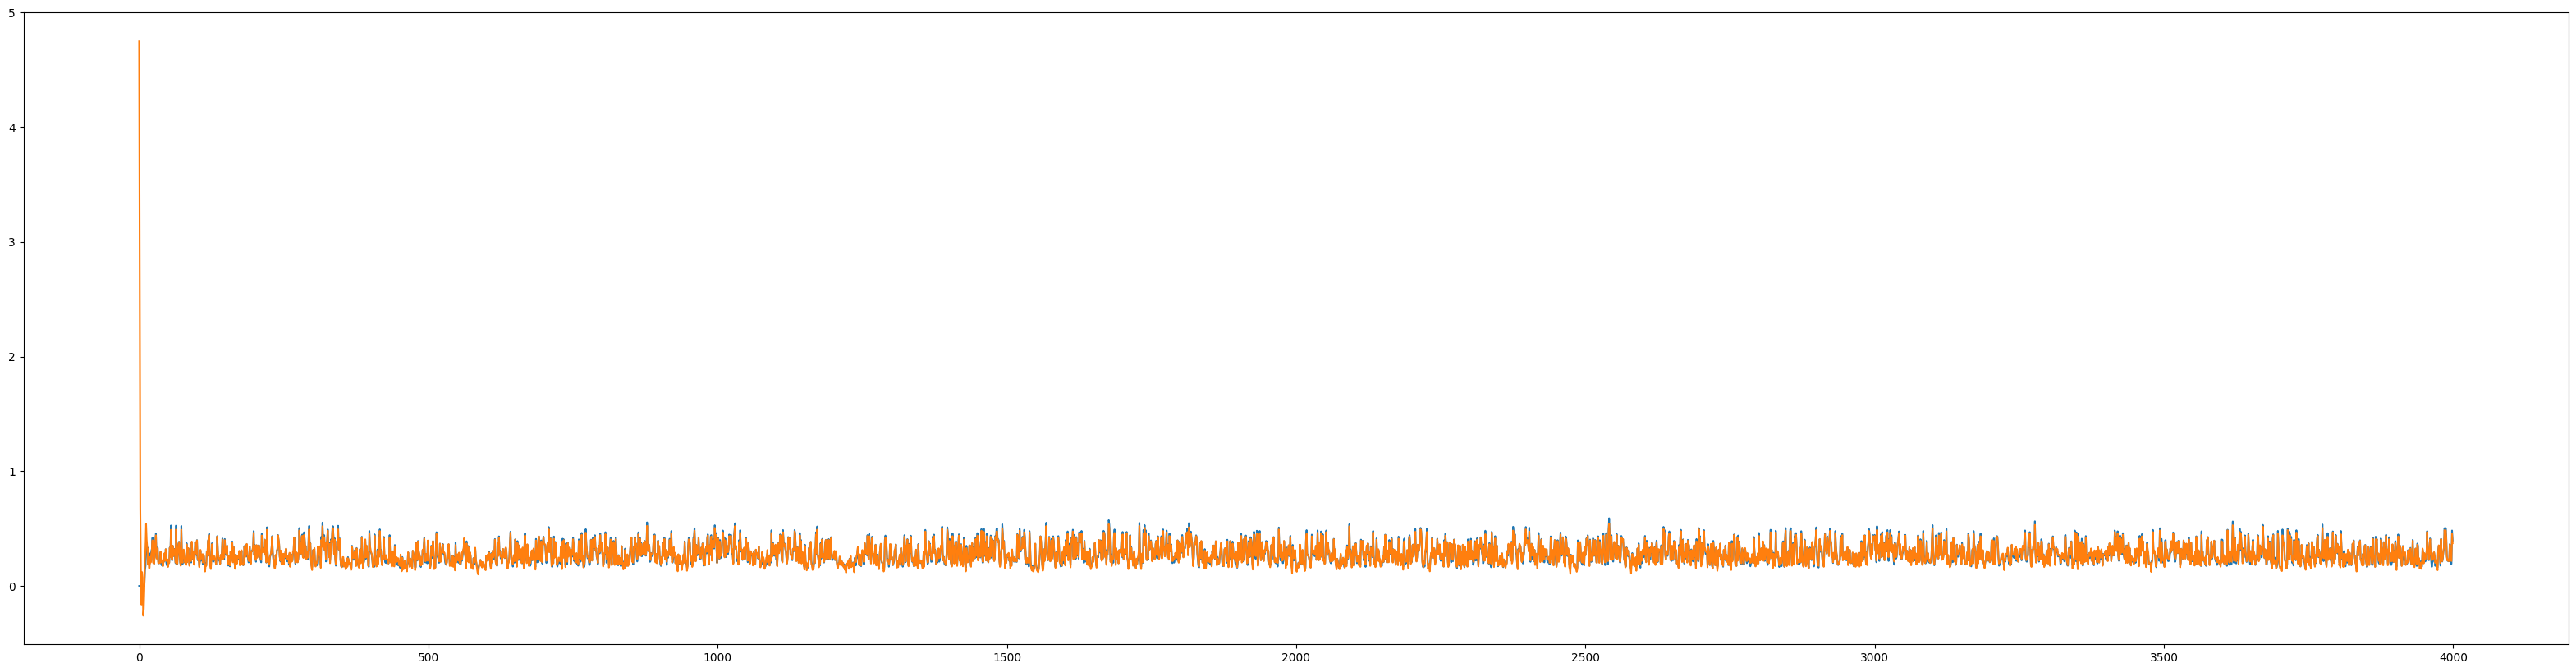

In [68]:
pred = esn(train_x, None)

plt.figure(figsize=(40, 10))
plt.plot(train_y, label='true')
plt.plot(pred, label='pred')